In [2]:
%matplotlib inline

import random 
import nbconvert
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import pandas as pd 
from operator import itemgetter
from matplotlib.pyplot import figure
from scipy import stats
from sklearn import metrics
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import f1_score




# (a) Parsing through data

In [3]:
trainingSet = pd.read_csv("/Users/nakulyadav/Desktop/Acads/appliedML_CornellTech/hw2/nlp-getting-started/train.csv")
testingSet = pd.read_csv("/Users/nakulyadav/Desktop/Acads/appliedML_CornellTech/hw2/nlp-getting-started/test.csv")

print("Number of training points are", trainingSet.shape[0])
print("Number of testing points are", testingSet.shape[0])

print("Number of tweets with real disaster information is", sum(trainingSet['target']==1))
print("Percentage of tweets with real disaster information is", sum(trainingSet['target']==1)*100/trainingSet.shape[0])

print("Number of tweets with real disaster information is", sum(trainingSet['target']==0))
print("Number of tweets with real disaster information is", sum(trainingSet['target']==0)*100/trainingSet.shape[0])



Number of training points are 7613
Number of testing points are 3263
Number of tweets with real disaster information is 3271
Percentage of tweets with real disaster information is 42.965979246026535
Number of tweets with real disaster information is 4342
Number of tweets with real disaster information is 57.034020753973465


# (b) Splitting data into training and dev set

In [4]:
import sys 
from sklearn.model_selection import train_test_split
trainData, devdata = train_test_split(trainingSet, test_size=0.3, random_state=30, shuffle=True)

print(trainData.shape)
print(devdata.shape)

(5329, 5)
(2284, 5)


# (c) Preprocessing function 

    We will call this function to pre-process data instead of passing this as a callable function in count_vectorizer function
    
    Here we have used 
    (a) lower case all words
    (b) wordnet lemmatizer
    (c) stop words removal
    (d) posterstemmer to stem the words

In [5]:
import sys 

from sklearn.model_selection import train_test_split
trainData, devdata = train_test_split(trainingSet, test_size=0.3, random_state=30, shuffle=True)

import nltk

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer 
from nltk.stem import WordNetLemmatizer


ps = PorterStemmer()
lemmer=WordNetLemmatizer()

stop_words = set(stopwords.words('english')) 

def processingRawTweets(trainData):
    trainData_proc = trainData['text'].copy()
    for sentence in range(trainData['text'].shape[0]):
        sentenceSelect = trainData['text'].iloc[sentence].lower()
        sentenceToken=[]
        filtered_sentence=[]
        sentenceToken = word_tokenize(sentenceSelect)
        filtered_sentence = [w for w in sentenceToken if not w in stop_words] 
        stem_sentence=[]
        stemmed_words=[ps.stem(word=word) for word in filtered_sentence]
        lemma_words=[lemmer.lemmatize(word=word) for word in stemmed_words]
       # for word in filtered_sentence:
        #    word = ps.stem(word)
        #    word = lemmer.lemmatize(word)
        #    stem_sentence.append(word)

        #trainData_proc.iloc[sentence]= (stem_sentence)
        trainData_proc.iloc[sentence]= ' '.join(lemma_words)
    return trainData_proc
    

# (d) Bag of words model : building vocabulary 

In [6]:
from sklearn.feature_extraction.text import CountVectorizer 

trainData_proc = processingRawTweets(trainData)
devdata_proc = processingRawTweets(devdata)

count_Vect = CountVectorizer(analyzer='word',binary="True",min_df=10,stop_words='english',tokenizer=word_tokenize)
trainVocab = count_Vect.fit_transform(trainData_proc)
dev_data_train = count_Vect.transform(devdata_proc)

print(trainData_proc.shape)
print(trainVocab.shape)
print(dev_data_train.shape)




(5329,)
(5329, 1004)
(2284, 1004)


# (e) Implementing a naive bayes model 

We make a model to find values of psis and phis and then use that for NB predictions.

In [92]:
X_train= trainVocab
y_train = trainData.target

n = trainVocab.shape[0] # size of the dataset
d = trainVocab.shape[1] # number of features in our dataset
K = 2 # number of clases

# these are the shapes of the parameters
psis = np.zeros([K,d])
phis = np.zeros([K])

# we now compute the parameters
for k in range(K):
    X_k = X_train[y_train == k]
    psis[k] = np.mean(X_k, axis=0)
    phis[k] = X_k.shape[0] / float(n)

# print out the class proportions
print(phis)

[0.57215237 0.42784763]


In [93]:
# we can implement this in numpy
def nb_predictions(x, psis, phis, K):
    """This returns class assignments and scores under the NB model.
    
    We compute \arg\max_y p(y|x) as \arg\max_y p(x|y)p(y)
    """
    # adjust shapes
    n, d=x.shape
    x=np.reshape(x.toarray(), (1,n,d))
    psis=np.reshape(psis, (K,1,d))
    
    # clip probabilities to avoid log(0)
    psis = psis.clip(1e-14, 1-1e-14)
    
    # compute log-probabilities
    logpy = np.log(phis).reshape([K,1])
    logpxy = x * np.log(psis) + (1-x) * np.log(1-psis)
    logpyx = logpxy.sum(axis=2) + logpy

    return logpyx.argmax(axis=0).flatten(), logpyx.reshape([K,n])

#predicting though Naive Bayes model on dev_data_train

predicted_NB, logpyx = nb_predictions(dev_data_train, psis, phis, 2)
accuracy = (predicted_NB==devdata['target']).mean()

#Printing accuracy and F1Score
print('The accuracy of NB model prediction is', accuracy)
print('And the F1 score is ', f1_score(devdata['target'], predicted_NB))

accuracy_bow_NBmodel = accuracy
f1score_bow_NBmodel =  f1_score(devdata['target'], predicted_NB)

The accuracy of NB model prediction is 0.7714535901926445
And the F1 score is  0.7217484008528785


# (f) Logistic regression 


In [94]:
#LOGISTIC REGRESSION

from sklearn.linear_model import LogisticRegression

#creating the model for regression
logreg = LogisticRegression(C=1e4, verbose=True, max_iter=300)
logreg.fit(trainVocab, trainData.target )

#predicting the output of dev data
predicted_logistic = logreg.predict(dev_data_train)

accuracy = (predicted_logistic==devdata['target']).mean()

print('The accuracy of NB model prediction is', accuracy)
print('And the F1 score is ', f1_score(devdata['target'], predicted_logistic))

accuracy_bow_logisticReg = accuracy
f1score_bow_logisticReg =  f1_score(devdata['target'], predicted_logistic)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The accuracy of NB model prediction is 0.7570052539404554
And the F1 score is  0.7101827676240209


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


In [95]:
#finding some important features extracted using Logistic regression
import heapq

weights = np.transpose(logreg.coef_)
index = heapq.nlargest(10, range(len(weights)), weights.__getitem__)

wordFeatures = count_Vect.get_feature_names()

print('Top 10 features with high weights are :')
for idx in index:
    print(wordFeatures[idx])



Top 10 features with high weights are :
wildfir
chile
funtenna
ebola
crane
mh370
migrant
civilian
myanmar
turkey


# (g) Using Linear SVM for classification

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


The c value hyperparameter I would select because it gives max. f1 score is  1
The accuracy of NB model prediction is 0.7740805604203153
And the F1 score is  0.7275607180570222
Top 10 features with high weights are :
wildfir
chile
mh370
crane
myanmar
ebola
turkey
bigger
civilian
migrant


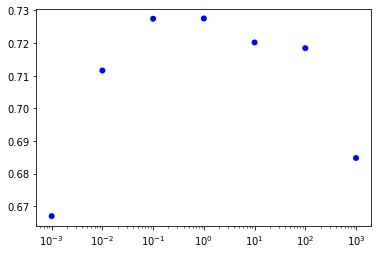

In [99]:
from sklearn.svm import LinearSVC
import heapq

cValsInitialisation = [0.001, 0.01,0.1,1,10,100,1000]
score = []
accuracy = []

for cval in cValsInitialisation:
    
    svcModel = LinearSVC(C=cval, max_iter = 3000)
    svcModel.fit(trainVocab, trainData.target)
    predicted_linearsvc = svcModel.predict(dev_data_train)
    correctAccuracy = (predicted_linearsvc==devdata['target']).mean()
    f1Val = f1_score(devdata['target'], predicted_linearsvc)
    score.append(f1Val)
    accuracy.append(correctAccuracy)
 

fig = plt.figure()
ax = plt.gca()
ax.scatter(cValsInitialisation ,score , c='blue', edgecolors='none')
ax.set_xscale('log')


index = heapq.nlargest(1, range(len(score)), score.__getitem__)
print("The c value hyperparameter I would select because it gives max. f1 score is ", cValsInitialisation[index[0]])

print('The accuracy of NB model prediction is', accuracy[index[0]])
print('And the F1 score is ', score[index[0]])

accuracy_bow_linearsvm = accuracy[index[0]]
f1score_bow_linearsvm =  score[index[0]]

#finding features that mattered the most

weightsLinearSVC = np.transpose(svcModel.coef_)
index = heapq.nlargest(10, range(len(weightsLinearSVC)), weightsLinearSVC.__getitem__)

wordFeatures = count_Vect.get_feature_names()

print('Top 10 features with high weights are :')

for idx in index:
    print(wordFeatures[idx])





Many words match however, there are also equal representation of words that dont match, which shows the underlying difference in how these algorithms work differently for classification

# (h) Non-Linear SVM

The c value hyperparameter I would select because it gives max. f1 score is  1
The accuracy of NB model prediction is 0.7885288966725044
And the F1 score is  0.7238421955403086


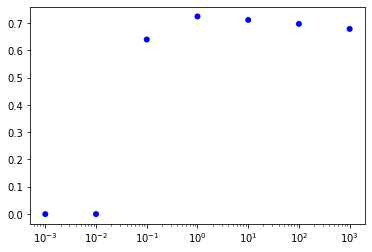

In [100]:
#Gaussian SVM prediction

from sklearn.svm import SVC

cValsInitialisation = [0.001, 0.01,0.1,1,10,100,1000]
score = []
accuracy =[]

for cval in cValsInitialisation:
    
    svcModel_nl = SVC(C=cval, kernel='rbf')
    svcModel_nl.fit(trainVocab, trainData.target)
    predicted_rbfsvc = svcModel_nl.predict(dev_data_train)
    correctAccuracy = (predicted_rbfsvc==devdata['target']).mean()
    f1Val = f1_score(devdata['target'], predicted_rbfsvc)
    score.append(f1Val)
    accuracy.append(correctAccuracy)
 

fig = plt.figure()
ax = plt.gca()
ax.scatter(cValsInitialisation ,score , c='blue', edgecolors='none')
ax.set_xscale('log')

index = heapq.nlargest(1, range(len(score)), score.__getitem__)
print("The c value hyperparameter I would select because it gives max. f1 score is ", cValsInitialisation[index[0]])

print('The accuracy of NB model prediction is', accuracy[index[0]])
print('And the F1 score is ', score[index[0]])

accuracy_bow_nonlinearsvm = accuracy[index[0]]
f1score_bow_nonlinearsvm =  score[index[0]]




# (i) n-gram model of unigram and bigram 

In [5]:
from sklearn.feature_extraction.text import CountVectorizer 

trainData_proc = processingRawTweets(trainData)
devdata_proc = processingRawTweets(devdata)


count_Vect = CountVectorizer(analyzer='word',binary="True",min_df=10,stop_words='english',tokenizer=word_tokenize, ngram_range=(1,2))
trainVocab = count_Vect.fit_transform(trainData_proc)
dev_data_train = count_Vect.transform(devdata_proc)

print(trainData_proc.shape)
print(trainVocab.shape)
print(dev_data_train.shape)

count_Vect.get_feature_names()

(5329,)
(5329, 1345)
(2284, 1345)


['!',
 '! !',
 '! #',
 "! '",
 '! :',
 '! ?',
 '! @',
 '! heard',
 '! http',
 '! unconfirm',
 '#',
 '# #',
 '# ?',
 '# best',
 '# earthquak',
 '# gbbo',
 '# hiroshima',
 '# hot',
 '# isi',
 '# islam',
 '# job',
 '# news',
 '# nowplay',
 '# prebreak',
 '# wildfir',
 '$',
 '%',
 '&',
 '& amp',
 '& gt',
 '& lt',
 "'",
 "' #",
 "' -",
 "' .",
 "' :",
 "' @",
 "' disea",
 "' http",
 "' mh370",
 "'conclus",
 "'conclus confirm",
 "'d",
 "'it",
 "'ll",
 "'m",
 "'re",
 "'re pick",
 "'s",
 "'s .",
 "'s like",
 "'s new",
 "'s stock",
 "'the",
 "'ve",
 "'we",
 "'we 're",
 '(',
 '( deton',
 '( photo',
 ')',
 ') -',
 ') :',
 ') http',
 ') sensor-senso',
 '*',
 '* *',
 '+',
 '-',
 '- ...',
 '- @',
 '- abc',
 '- http',
 '- read',
 '- re\x89û_',
 '--',
 '.',
 '. #',
 ". '",
 ". 'm",
 ". 's",
 '. -',
 '. .',
 '. ?',
 '. @',
 '. appear',
 '. ca',
 '. http',
 ". n't",
 '. thank',
 '..',
 '...',
 '... #',
 '... -',
 '... http',
 '....',
 '.... http',
 '.....',
 '/',
 '1',
 '10',
 '100',
 '11',
 '12',
 '120

In [35]:
import random

words = (count_Vect.get_feature_names())
unigram=0
bigram=0
index_unigram=[]
index_bigram=[]

for w in range(len(words)):
    if len(words[w].split())==1:
        unigram = unigram+1
        index_unigram.append(w)
    elif len(words[w].split())==2:
        bigram = bigram+1
        index_bigram.append(w)
        
print("number of unigrams are : " + str(unigram) + ' ' + "and number of 2grams are  : " + ' ' + str(bigram))
        
        
#randomly sampling 1gram and 2gram features
randomIndexSampleIndex_unigram = random.sample(index_unigram, 10)
randomIndexSampleIndex_bigram = random.sample(index_bigram, 10)


print('Examples of unigrams are : ')
for x in range(10):
    print(words[randomIndexSampleIndex_unigram[x]])
    
print('Examples of bigrams are : ')
for x in range(10):
    print(words[randomIndexSampleIndex_bigram[x]])

number of unigrams are : 1004 and number of 2grams are  :  341
Examples of unigrams are : 
ancient
babi
aircraft
arriv
hail
lord
sink
legionnair
book
pile
Examples of bigrams are : 
pm :
? :
refugio oil
latest :
wildfir -
gon na
wave isra
miner releas
unconfirm !
ban quarantin


# Naive Bayes on n-gram

In [102]:
#naive bayes on ngram model 

X_train= trainVocab
y_train = trainData.target

n = trainVocab.shape[0] # size of the dataset
d = trainVocab.shape[1] # number of features in our dataset
K = 2 # number of clases

# these are the shapes of the parameters
psis = np.zeros([K,d])
phis = np.zeros([K])

# we now compute the parameters
for k in range(K):
    X_k = X_train[y_train == k]
    psis[k] = np.mean(X_k, axis=0)
    phis[k] = X_k.shape[0] / float(n)

#model is already made so we just use it by passing new matrix
predicted_NB, logpyx = nb_predictions(dev_data_train, psis, phis, 2)

accuracy = (predicted_NB==devdata['target']).mean()

#Printing accuracy and F1Score
print('The accuracy of NB model prediction is', accuracy)
print('And the F1 score is ', f1_score(devdata['target'], predicted_NB))

accuracy_ngram_NBmodel = accuracy
f1score_ngram_NBmodel =  f1_score(devdata['target'], predicted_NB)

The accuracy of NB model prediction is 0.7683887915936952
And the F1 score is  0.7151319332256327


# logistic regression on n-gram

In [103]:
#LOGISTIC REGRESSION

from sklearn.linear_model import LogisticRegression

#creating the model for regression
logreg = LogisticRegression(C=1e4, verbose=True, max_iter=300)
logreg.fit(trainVocab, trainData.target )

#predicting the output of dev data
predicted_logistic = logreg.predict(dev_data_train)

accuracy = (predicted_logistic==devdata['target']).mean()

print('The accuracy of logistic model prediction is', accuracy)
print('And the F1 score is ', f1_score(devdata['target'], predicted_logistic))

#finding some important features extracted using Logistic regression
import heapq

weights = np.transpose(logreg.coef_)
index = heapq.nlargest(10, range(len(weights)), weights.__getitem__)

wordFeatures = count_Vect.get_feature_names()

print('Top 10 features with high weights are :')
for idx in index:
    print(wordFeatures[idx])

accuracy_ngram_logisticReg = accuracy
f1score_ngram_logisticReg =  f1_score(devdata['target'], predicted_logistic)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The accuracy of logistic model prediction is 0.7548161120840631
And the F1 score is  0.712230215827338
Top 10 features with high weights are :
wildfir
migrant
ebola
mh370
crane
flash flood
bigger
crisi
expert
libya


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


# Linear SVM on n-gram

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


The c value hyperparameter I would select because it gives max. f1 score is  0.1
The accuracy of linear svm prediction is 0.7810858143607706
And the F1 score is  0.7282608695652173
Top 10 features with high weights are :
migrant
wildfir
mh370
spill
flash flood
incid
bigger
ebola
isra
myanmar


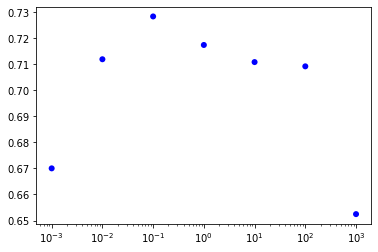

In [104]:
from sklearn.svm import LinearSVC
import heapq

cValsInitialisation = [0.001, 0.01,0.1,1,10,100,1000]
score = []
accuracy = []

for cval in cValsInitialisation:
    
    svcModel = LinearSVC(C=cval, max_iter = 3000)
    svcModel.fit(trainVocab, trainData.target)
    predicted_linearsvc = svcModel.predict(dev_data_train)
    correctAccuracy = (predicted_linearsvc==devdata['target']).mean()
    f1Val = f1_score(devdata['target'], predicted_linearsvc)
    score.append(f1Val)
    accuracy.append(correctAccuracy)
 

fig = plt.figure()
ax = plt.gca()
ax.scatter(cValsInitialisation ,score , c='blue', edgecolors='none')
ax.set_xscale('log')


index = heapq.nlargest(1, range(len(score)), score.__getitem__)
print("The c value hyperparameter I would select because it gives max. f1 score is ", cValsInitialisation[index[0]])

print('The accuracy of linear svm prediction is', accuracy[index[0]])
print('And the F1 score is ', score[index[0]])

accuracy_ngram_linearsvm = accuracy[index[0]]
f1score_ngram_linearsvm =  score[index[0]]


#finding features that mattered the most

weightsLinearSVC = np.transpose(svcModel.coef_)
index = heapq.nlargest(10, range(len(weightsLinearSVC)), weightsLinearSVC.__getitem__)

wordFeatures = count_Vect.get_feature_names()

print('Top 10 features with high weights are :')

for idx in index:
    print(wordFeatures[idx])





# Non-linear SVM on n-gram

The c value hyperparameter I would select because it gives max. f1 score is  10
The accuracy of non-linear svm prediction is 0.7714535901926445
And the F1 score is  0.7208556149732621


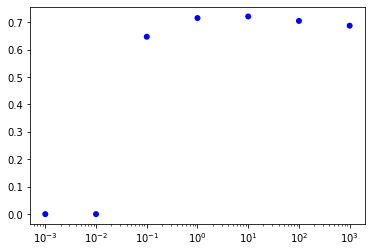

In [105]:
#Gaussian SVM prediction

from sklearn.svm import SVC

cValsInitialisation = [0.001, 0.01,0.1,1,10,100,1000]
score = []
accuracy =[]

for cval in cValsInitialisation:
    
    svcModel_nl = SVC(C=cval, kernel='rbf')
    svcModel_nl.fit(trainVocab, trainData.target)
    predicted_rbfsvc = svcModel_nl.predict(dev_data_train)
    correctAccuracy = (predicted_rbfsvc==devdata['target']).mean()
    f1Val = f1_score(devdata['target'], predicted_rbfsvc)
    score.append(f1Val)
    accuracy.append(correctAccuracy)
 

fig = plt.figure()
ax = plt.gca()
ax.scatter(cValsInitialisation ,score , c='blue', edgecolors='none')
ax.set_xscale('log')

index = heapq.nlargest(1, range(len(score)), score.__getitem__)
print("The c value hyperparameter I would select because it gives max. f1 score is ", cValsInitialisation[index[0]])

print('The accuracy of non-linear svm prediction is', accuracy[index[0]])
print('And the F1 score is ', score[index[0]])

accuracy_ngram_nonlinearsvm = accuracy[index[0]]
f1score_ngram_nonlinearsvm =  score[index[0]]




# (j) Incorpoorating location and keywords

We do this by appending location and keyword to the tweet itself during training and testing dataset
I also replace NaN's with 'none' string


In [106]:
trainingSet = pd.read_csv("/Users/nakulyadav/Desktop/Acads/appliedML_CornellTech/hw2/nlp-getting-started/train.csv")
testingSet = pd.read_csv("/Users/nakulyadav/Desktop/Acads/appliedML_CornellTech/hw2/nlp-getting-started/test.csv")

trainingSet.fillna('none', inplace=True)
testingSet.fillna('none', inplace=True)


#Adding Location and Keywords
trainingSet['newtext'] = trainingSet['location'] +' '+ trainingSet['keyword'] + ' '+trainingSet['text']
testingSet['newtext'] = testingSet['location'] + ' '+testingSet['keyword'] + ' '+testingSet['text']

#split training into train and dev dataset

from sklearn.model_selection import train_test_split
trainData, devdata = train_test_split(trainingSet, test_size=0.3, random_state=30, shuffle=True)

import nltk

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer 
from nltk.stem import WordNetLemmatizer

ps = PorterStemmer()
lemmer=WordNetLemmatizer()

stop_words = set(stopwords.words('english')) 

def processingRawTweetsNew(trainData):
    trainData_proc = trainData['newtext'].copy()
    for sentence in range(trainData['newtext'].shape[0]):
        sentenceSelect = trainData['newtext'].iloc[sentence].lower()
        sentenceToken=[]
        filtered_sentence=[]
        sentenceToken = word_tokenize(sentenceSelect)
        filtered_sentence = [w for w in sentenceToken if not w in stop_words] 
        stem_sentence=[]
        stemmed_words=[ps.stem(word=word) for word in filtered_sentence]
        lemma_words=[lemmer.lemmatize(word=word) for word in stemmed_words]
        trainData_proc.iloc[sentence]= ' '.join(lemma_words)
    return trainData_proc



# making bag of words model on modified Dataset

In [107]:
from sklearn.feature_extraction.text import CountVectorizer 

trainData_proc = processingRawTweetsNew(trainData)
devdata_proc = processingRawTweetsNew(devdata)

count_Vect = CountVectorizer(analyzer='word',binary="True",min_df=10,stop_words='english',tokenizer=word_tokenize)
trainVocab = count_Vect.fit_transform(trainData_proc)
dev_data_train = count_Vect.transform(devdata_proc)

print(trainData_proc.shape)
print(trainVocab.shape)




(5329,)
(5329, 1154)


# naive Bayes on mod.data


In [108]:
#naive bayes on ngram model 

X_train= trainVocab
y_train = trainData.target

n = trainVocab.shape[0] # size of the dataset
d = trainVocab.shape[1] # number of features in our dataset
K = 2 # number of clases

# these are the shapes of the parameters
psis = np.zeros([K,d])
phis = np.zeros([K])

# we now compute the parameters
for k in range(K):
    X_k = X_train[y_train == k]
    psis[k] = np.mean(X_k, axis=0)
    phis[k] = X_k.shape[0] / float(n)

#model is already made so we just use it by passing new matrix
predicted_NB, logpyx = nb_predictions(dev_data_train, psis, phis, 2)

accuracy = (predicted_NB==devdata['target']).mean()

#Printing accuracy and F1Score
print('The accuracy of NB model prediction is', accuracy)
print('And the F1 score is ', f1_score(devdata['target'], predicted_NB))

accuracy_moddata_NBmodel = accuracy
f1score_moddata_NBmodel =  f1_score(devdata['target'], predicted_NB)

The accuracy of NB model prediction is 0.7697022767075307
And the F1 score is  0.7213983050847458


# logistic regression on mod. data

In [109]:
#LOGISTIC REGRESSION

from sklearn.linear_model import LogisticRegression

#creating the model for regression
logreg = LogisticRegression(C=1e4, verbose=True, max_iter=300)
logreg.fit(trainVocab, trainData.target )

#predicting the output of dev data
predicted_logistic = logreg.predict(dev_data_train)

accuracy = (predicted_logistic==devdata['target']).mean()

print('The accuracy of logistic model prediction is', accuracy)
print('And the F1 score is ', f1_score(devdata['target'], predicted_logistic))

#finding some important features extracted using Logistic regression
import heapq

weights = np.transpose(logreg.coef_)
index = heapq.nlargest(10, range(len(weights)), weights.__getitem__)

wordFeatures = count_Vect.get_feature_names()

print('Top 10 features with high weights are :')
for idx in index:
    print(wordFeatures[idx])

accuracy_moddata_logisticReg = accuracy
f1score_moddata_logisticReg =  f1_score(devdata['target'], predicted_logistic)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The accuracy of logistic model prediction is 0.7535026269702276
And the F1 score is  0.7063119457485655
Top 10 features with high weights are :
mh370
libya
debri
chile
airplan
myanmar
villag
funtenna
migrant
crane


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


# linear svm on mod data

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


The c value hyperparameter I would select because it gives max. f1 score is  0.1
The accuracy of linear svm prediction is 0.7828371278458844
And the F1 score is  0.7295528898582335
Top 10 features with high weights are :
mh370
libya
chile
airplan
debri
migrant
spill
typhoon
20murder
wildfir


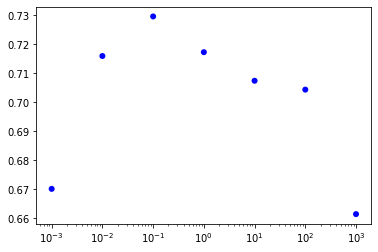

In [110]:
from sklearn.svm import LinearSVC
import heapq

cValsInitialisation = [0.001, 0.01,0.1,1,10,100,1000]
score = []
accuracy = []

for cval in cValsInitialisation:
    
    svcModel = LinearSVC(C=cval, max_iter = 3000)
    svcModel.fit(trainVocab, trainData.target)
    predicted_linearsvc = svcModel.predict(dev_data_train)
    correctAccuracy = (predicted_linearsvc==devdata['target']).mean()
    f1Val = f1_score(devdata['target'], predicted_linearsvc)
    score.append(f1Val)
    accuracy.append(correctAccuracy)
 

fig = plt.figure()
ax = plt.gca()
ax.scatter(cValsInitialisation ,score , c='blue', edgecolors='none')
ax.set_xscale('log')


index = heapq.nlargest(1, range(len(score)), score.__getitem__)
print("The c value hyperparameter I would select because it gives max. f1 score is ", cValsInitialisation[index[0]])

print('The accuracy of linear svm prediction is', accuracy[index[0]])
print('And the F1 score is ', score[index[0]])

accuracy_moddata_linearsvm = accuracy[index[0]]
f1score_moddata_linearsvm =  score[index[0]]

#finding features that mattered the most

weightsLinearSVC = np.transpose(svcModel.coef_)
index = heapq.nlargest(10, range(len(weightsLinearSVC)), weightsLinearSVC.__getitem__)

wordFeatures = count_Vect.get_feature_names()

print('Top 10 features with high weights are :')

for idx in index:
    print(wordFeatures[idx])




# non-linear svm on mod data

The c value hyperparameter I would select because it gives max. f1 score is  10
The accuracy of non-linear svm prediction is 0.7727670753064798
And the F1 score is  0.720817643894567


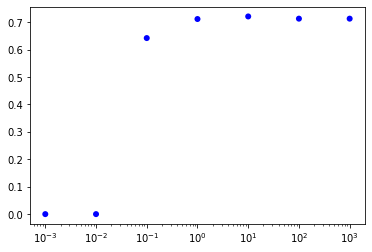

In [111]:
#Gaussian SVM prediction

from sklearn.svm import SVC

cValsInitialisation = [0.001, 0.01,0.1,1,10,100,1000]
score = []
accuracy =[]

for cval in cValsInitialisation:
    
    svcModel_nl = SVC(C=cval, kernel='rbf')
    svcModel_nl.fit(trainVocab, trainData.target)
    predicted_rbfsvc = svcModel_nl.predict(dev_data_train)
    correctAccuracy = (predicted_rbfsvc==devdata['target']).mean()
    f1Val = f1_score(devdata['target'], predicted_rbfsvc)
    score.append(f1Val)
    accuracy.append(correctAccuracy)
 

fig = plt.figure()
ax = plt.gca()
ax.scatter(cValsInitialisation ,score , c='blue', edgecolors='none')
ax.set_xscale('log')

index = heapq.nlargest(1, range(len(score)), score.__getitem__)
print("The c value hyperparameter I would select because it gives max. f1 score is ", cValsInitialisation[index[0]])

print('The accuracy of non-linear svm prediction is', accuracy[index[0]])
print('And the F1 score is ', score[index[0]])

accuracy_moddata_nonlinearsvm = accuracy[index[0]]
f1score_moddata_nonlinearsvm =  score[index[0]]



In [113]:

technique = ['1gramBOW','n_gram BOW','ModifiedData_1gramBOW']
accuracyDF = pd.DataFrame(columns=['Technique','NBmodel','LogisticReg','LinearSVM','NonLinearSVM'])
accuracyDF['Technique']=technique
accuracyDF['NBmodel']=[accuracy_bow_NBmodel, accuracy_ngram_NBmodel, accuracy_moddata_NBmodel]
accuracyDF['LogisticReg']=[accuracy_bow_logisticReg, accuracy_ngram_logisticReg ,accuracy_moddata_logisticReg]
accuracyDF['LinearSVM']=[accuracy_bow_linearsvm, accuracy_ngram_linearsvm ,accuracy_moddata_linearsvm]
accuracyDF['NonLinearSVM']=[accuracy_bow_nonlinearsvm, accuracy_ngram_nonlinearsvm ,accuracy_moddata_nonlinearsvm]


f1scoreDF = pd.DataFrame(columns=['Technique','NBmodel','LogisticReg','LinearSVM','NonLinearSVM'])
f1scoreDF['Technique']=technique
f1scoreDF['NBmodel']=[f1score_bow_NBmodel, f1score_ngram_NBmodel, f1score_moddata_NBmodel]
f1scoreDF['LogisticReg']=[f1score_bow_logisticReg, f1score_ngram_logisticReg, f1score_moddata_logisticReg]
f1scoreDF['LinearSVM']=[f1score_bow_linearsvm, f1score_ngram_linearsvm, f1score_moddata_linearsvm]
f1scoreDF['NonLinearSVM']=[f1score_bow_nonlinearsvm, f1score_ngram_nonlinearsvm, f1score_moddata_nonlinearsvm]



In [114]:
print(accuracyDF)

print(f1scoreDF)

               Technique   NBmodel  LogisticReg  LinearSVM  NonLinearSVM
0               1gramBOW  0.771454     0.757005   0.774081      0.788529
1             n_gram BOW  0.768389     0.754816   0.781086      0.771454
2  ModifiedData_1gramBOW  0.769702     0.753503   0.782837      0.772767
               Technique   NBmodel  LogisticReg  LinearSVM  NonLinearSVM
0               1gramBOW  0.721748     0.710183   0.727561      0.723842
1             n_gram BOW  0.715132     0.712230   0.728261      0.720856
2  ModifiedData_1gramBOW  0.721398     0.706312   0.729553      0.720818


# (k) Final model on Kaggle Testing Set 

I would use linear SVM on modifiedData with 1gram bag of words approach. The C value we use to linear svm is 0.1 as indicated from the our dev data model. 




In [7]:
trainingSet = pd.read_csv("/Users/nakulyadav/Desktop/Acads/appliedML_CornellTech/hw2/nlp-getting-started/train.csv")
testingSet = pd.read_csv("/Users/nakulyadav/Desktop/Acads/appliedML_CornellTech/hw2/nlp-getting-started/test.csv")

trainingSet.fillna('none', inplace=True)
testingSet.fillna('none', inplace=True)


#Adding Location and Keywords
trainingSet['newtext'] = trainingSet['location'] +' '+ trainingSet['keyword'] + ' '+trainingSet['text']
testingSet['newtext'] = testingSet['location'] + ' '+testingSet['keyword'] + ' '+testingSet['text']

import nltk

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer 
from nltk.stem import WordNetLemmatizer

ps = PorterStemmer()
lemmer=WordNetLemmatizer()

stop_words = set(stopwords.words('english')) 

def processingRawTweetsNew(trainData):
    trainData_proc = trainData['newtext'].copy()
    for sentence in range(trainData['newtext'].shape[0]):
        sentenceSelect = trainData['newtext'].iloc[sentence].lower()
        sentenceToken=[]
        filtered_sentence=[]
        sentenceToken = word_tokenize(sentenceSelect)
        filtered_sentence = [w for w in sentenceToken if not w in stop_words] 
        stem_sentence=[]
        stemmed_words=[ps.stem(word=word) for word in filtered_sentence]
        lemma_words=[lemmer.lemmatize(word=word) for word in stemmed_words]
        trainData_proc.iloc[sentence]= ' '.join(lemma_words)
    return trainData_proc

In [8]:
from sklearn.feature_extraction.text import CountVectorizer 

trainData_proc = processingRawTweetsNew(trainingSet)
devdata_proc = processingRawTweetsNew(testingSet)

count_Vect = CountVectorizer(analyzer='word',binary="True",min_df=10,stop_words='english',tokenizer=word_tokenize)
trainVocab = count_Vect.fit_transform(trainData_proc)
dev_data_train = count_Vect.transform(devdata_proc)

print(trainData_proc.shape)
print(trainVocab.shape)

print(trainingSet.target)

(7613,)
(7613, 1501)
0       1
1       1
2       1
3       1
4       1
       ..
7608    1
7609    1
7610    1
7611    1
7612    1
Name: target, Length: 7613, dtype: int64


In [9]:
#LINEAR SVM ON FINAL TESTING SET

from sklearn.svm import LinearSVC
import heapq

cValsInitialisation = [0.1]    

for cval in cValsInitialisation:
    
    svcModel = LinearSVC(C=cval, max_iter = 3000)
    svcModel.fit(trainVocab, trainingSet.target)
    predicted_linearsvc = svcModel.predict(dev_data_train)

#finding features that mattered the most

weightsLinearSVC = np.transpose(svcModel.coef_)
index = heapq.nlargest(25, range(len(weightsLinearSVC)), weightsLinearSVC.__getitem__)

wordFeatures = count_Vect.get_feature_names()

print('Top 25 features with high weights are :')

for idx in index:
    print(wordFeatures[idx])

print(predicted_linearsvc)

Top 25 features with high weights are :
wildfir
hiroshima
earthquak
debri
incid
typhoon
evacu
drought
villag
outbreak
bioterror
storm
karachi
massacr
collis
flood
volcano
explos
spill
migrant
horribl
20fire
civilian
sever
derail
[1 1 0 ... 1 1 0]


In [46]:
np.savetxt('predictionTarget.csv',predicted_linearsvc,delimiter=',',fmt='%s')

#Submitted the file and got an fscore of 0.78608. This is hgiher than we i anticipated but that is because i had mroe datapoints to
#train the model

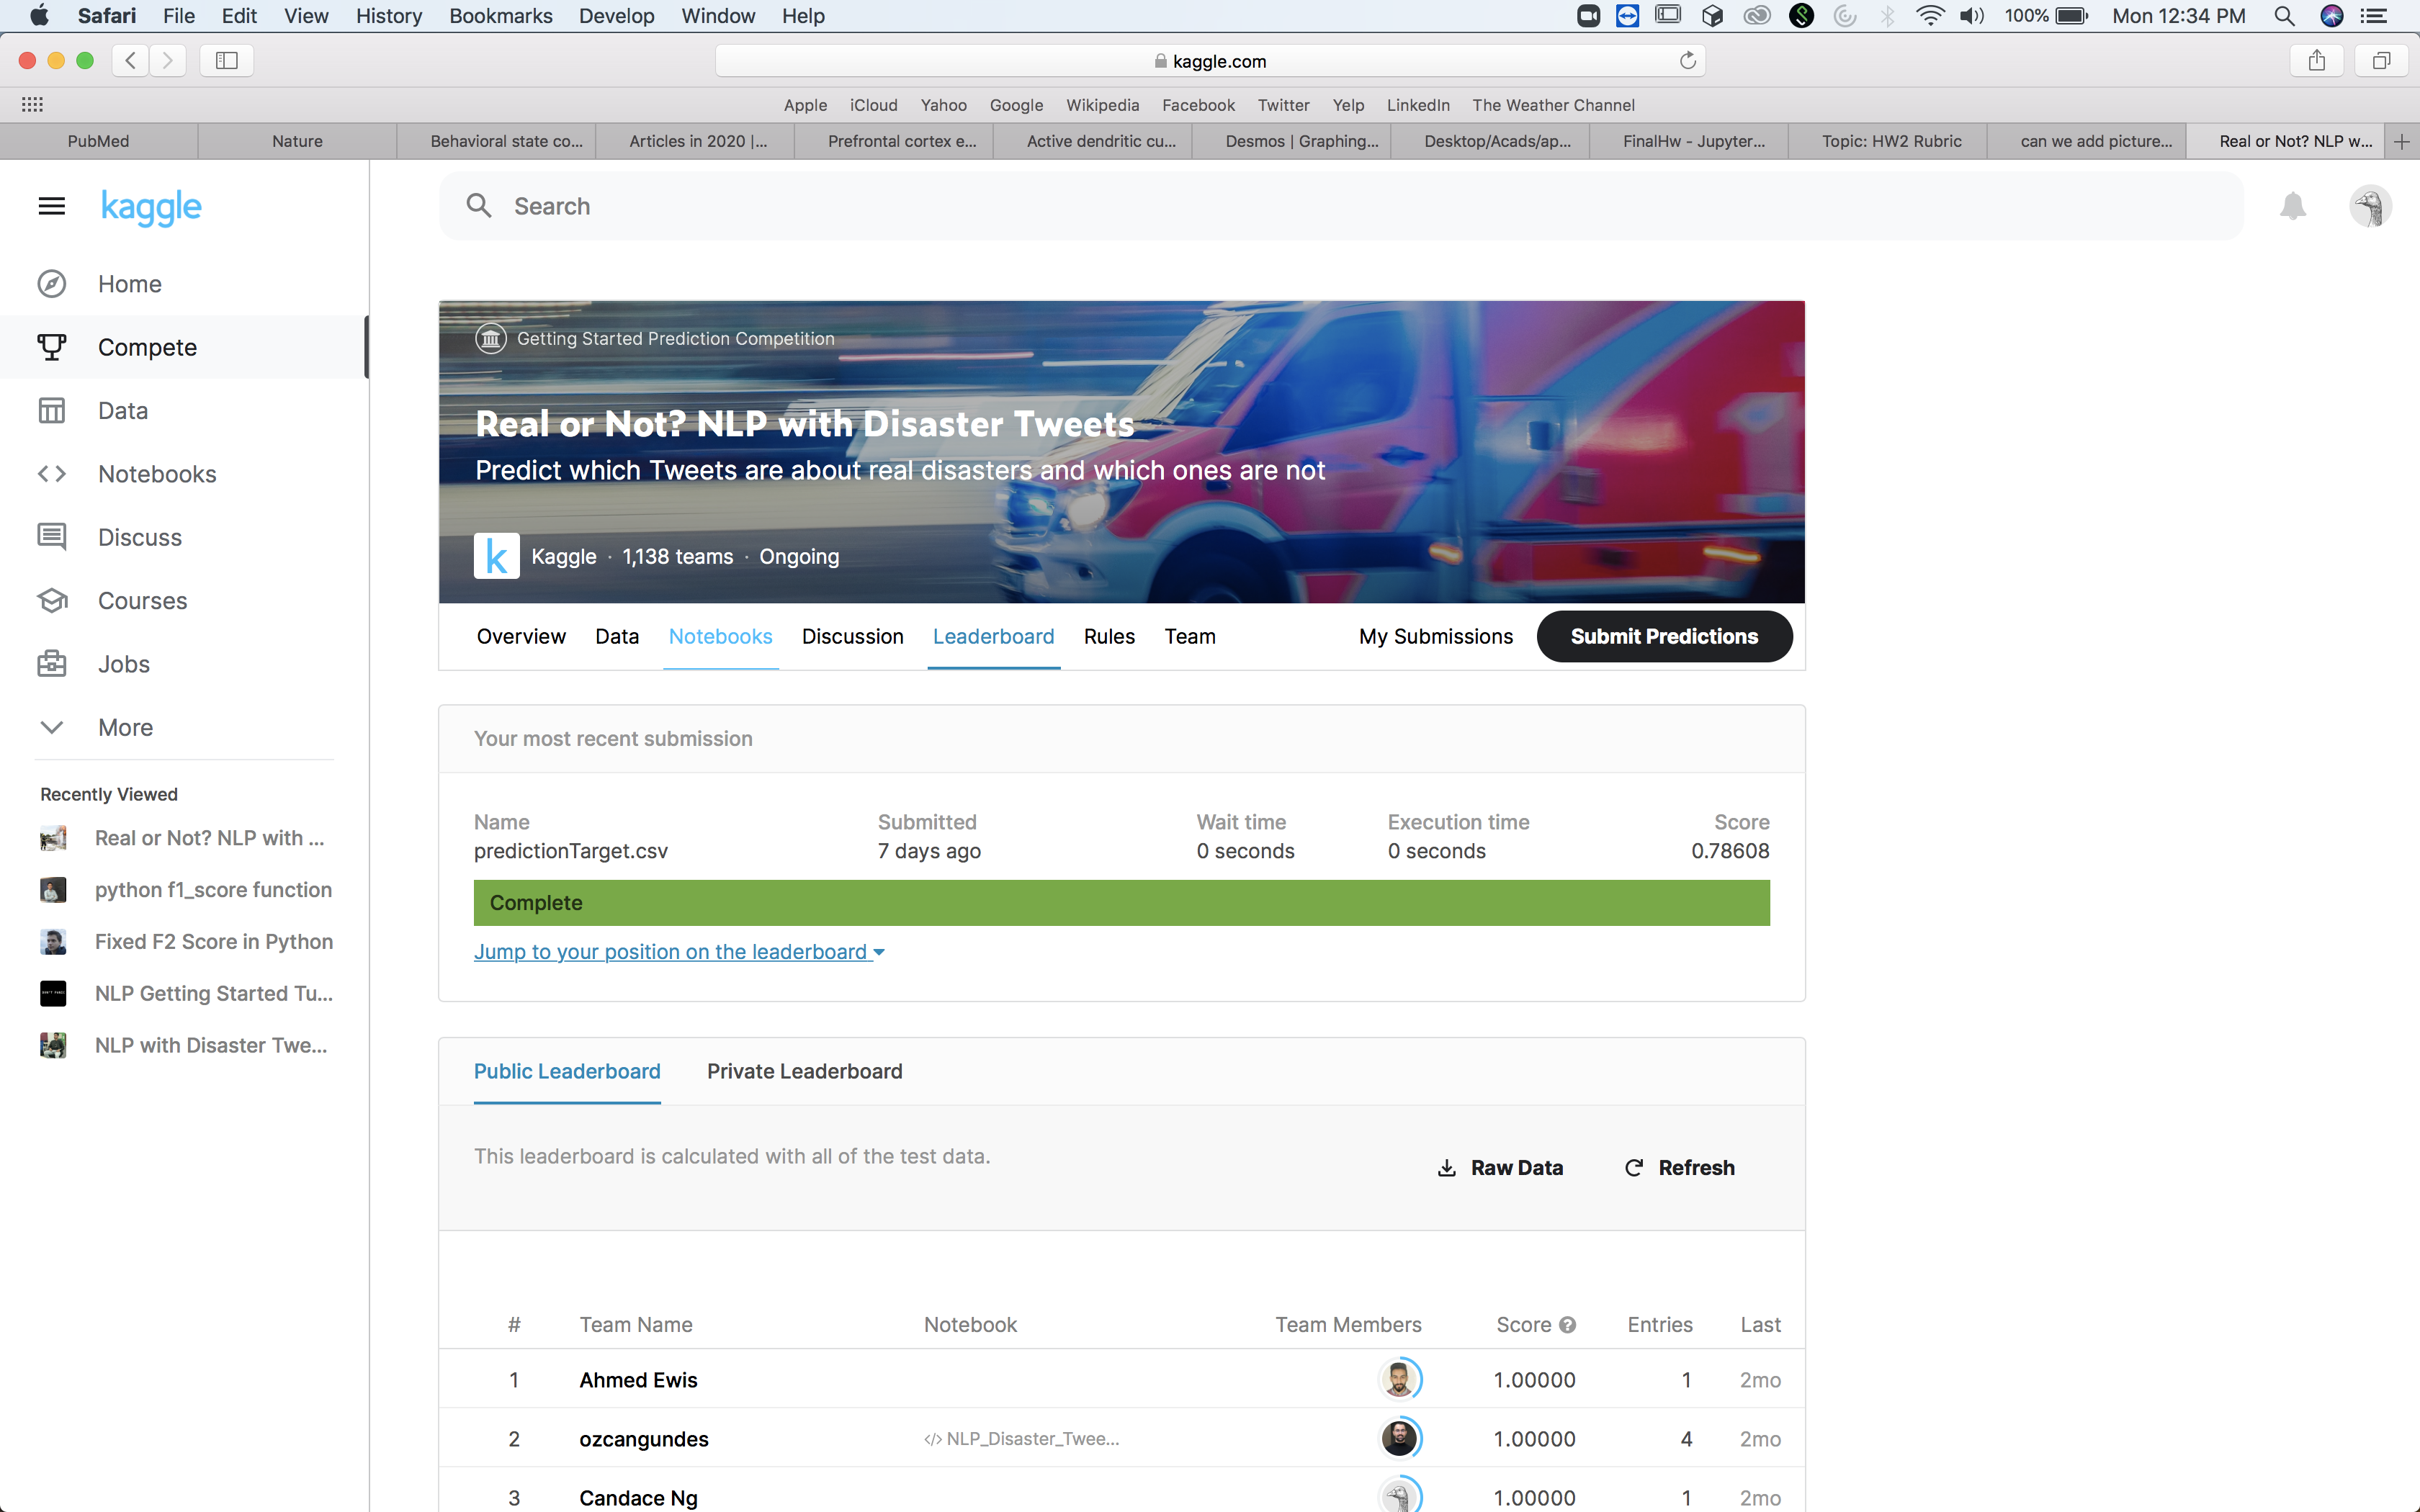

# (l) Reflecting on interpretability 



Based on our approach, our fscore and accuracy is good. It is preferable to use a linear approach for classification because it provides insight into the model being made. We can always go back and analyse the decision boundaries and reflect on the some variables which were highly weighted comapred to other variables while the classification boundaries were decided. 

Here we used Linear SVM, because, while SVM finds a maximum margin hyperplane, which is a good way to not overfit according to training data and make the model more general yet keeping it interpretable. Linear model helped us understand the features that really affected the boundary and hence, which features were weighted highly while making the decision. 

Here, i have printed top 25 features, and most of them indicate that these features were decisive to flag the tweets as "disasters" such as wildfire, drought, earthquake, flood, typhoon, storm etc which are all examples of natural disasters. Other features such as spill, explosion, massacre, bioterror etc are all examples of man-made disasters. This algorithm really worked to find out which tweets were disasters and which were not. 

Furthermore, we can also question now, whether these disasters were natural or man-made for further insights, which might be important for companies providings news, insurance etc. 
